In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
from glob import iglob
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
mpl.rcParams['axes.titlesize'] = 19
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['legend.markerscale'] = 2
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['figure.dpi'] = 100

sns.set_style('ticks')
colors = ["#e74c3c", "#3498db", "#95a5a6"]

sns.set_palette(sns.color_palette(colors))

# Collect basic information from idxstats and other qc metrics

In [3]:
!head -2 hek293_nih3t3_mix/picard_idxstats/HEK293T_NIH3T3_mix_001_f2q30_pmd.idxstats

hs_chr10	133797422	0	0
hs_chr11	135086622	0	0


In [4]:
!head -2 hek293_nih3t3_mix/qc_metrics/mapping_rate.txt

cell	mapping_rate
HEK293T_NIH3T3_mix_001	70.97


In [5]:
dfs = []

for i in iglob('hek293_nih3t3_mix/picard_idxstats/*.idxstats'):
    cell = i.split('/')[-1][:22]
    df = pd.read_table(i, header=None, usecols=[0,2], names=['chroms', cell],
                       index_col='chroms', comment='*')
    df['genomes'] = df.index.str.extract('(.*)_chr.*', expand=False)
    dfs.append(df.groupby('genomes').sum().T)

sample_info = pd.concat(dfs)

for fh in ['hek293_nih3t3_mix/qc_metrics/mapping_rate.txt',
           'hek293_nih3t3_mix/qc_metrics/sequencing_depth.txt']:
    df = pd.read_table(fh, index_col=0)
    sample_info = sample_info.join(df)

sample_info.head(2)

,hs,mm,mapping_rate,sequencing_depth
HEK293T_NIH3T3_mix_001,6,24,70.97,31
HEK293T_NIH3T3_mix_002,12,12,68.97,29


(10, 50000000.0)

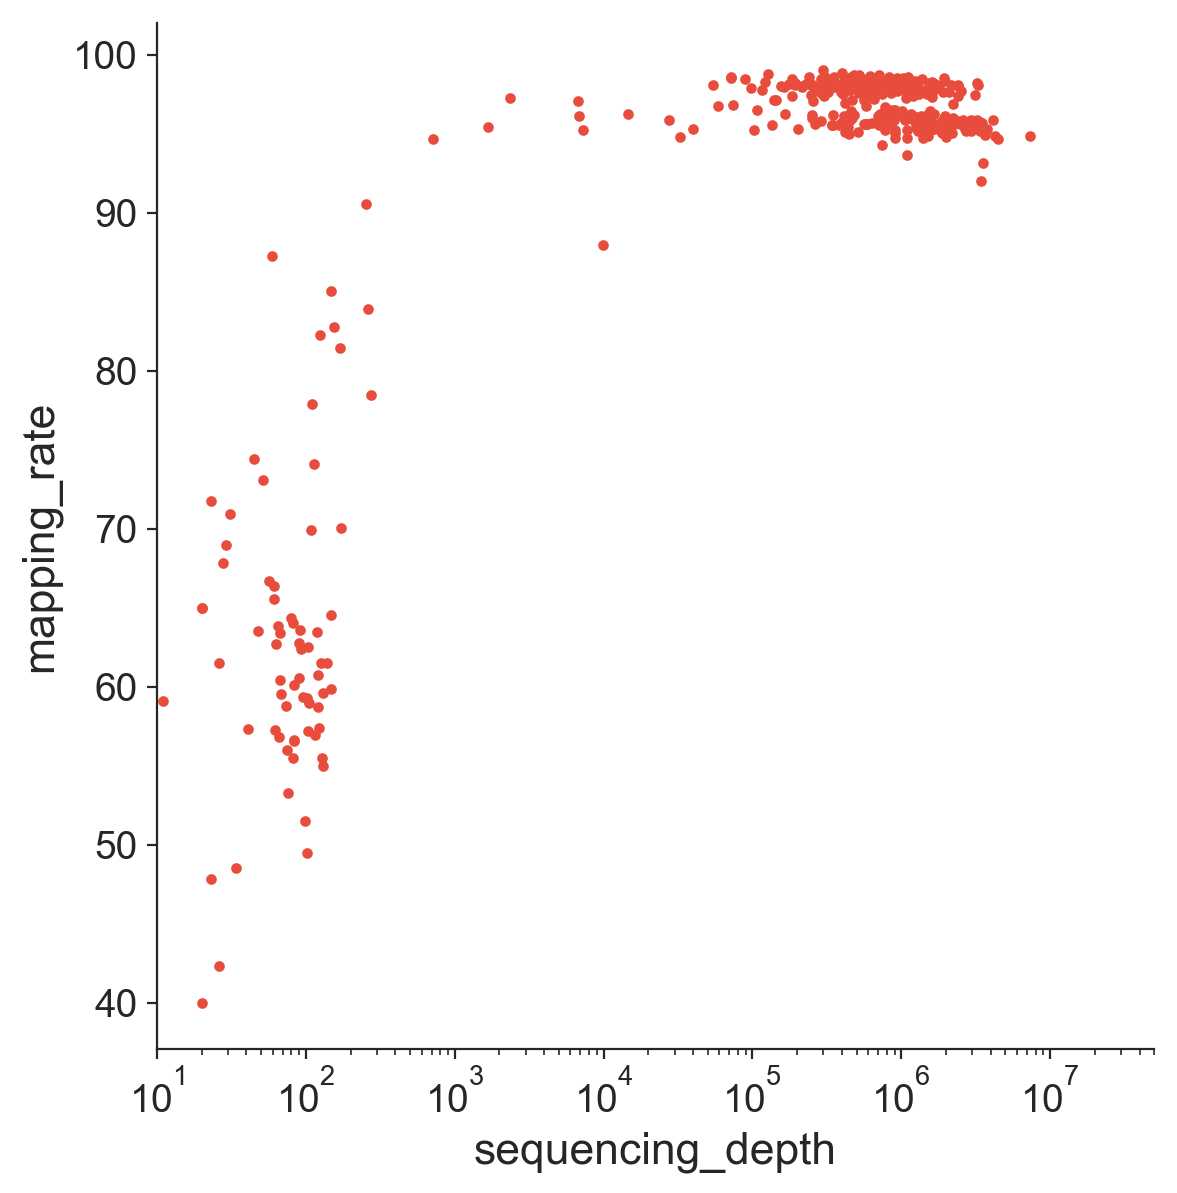

In [6]:
g = sns.FacetGrid(sample_info, height=6)
g.map(plt.scatter, 'sequencing_depth', 'mapping_rate', s=8)
g.ax.set_xscale('log')
g.ax.set_xlim(10, 5e7)

In [7]:
cells = sample_info.query('sequencing_depth > 1e4 & mapping_rate > 90').copy()
cells['ratio'] = cells.hs / cells.mm

In [8]:
cells.shape

(307, 5)

In [9]:
cells.loc[cells.query('ratio > 10').index, 'species'] = 'Human'
cells.loc[cells.query('ratio < .1').index, 'species'] = 'Mouse'

In [10]:
cells.fillna('Doublets', inplace=True)

In [11]:
cells.species.value_counts()

Human       167
Mouse       136
Doublets      4
Name: species, dtype: int64

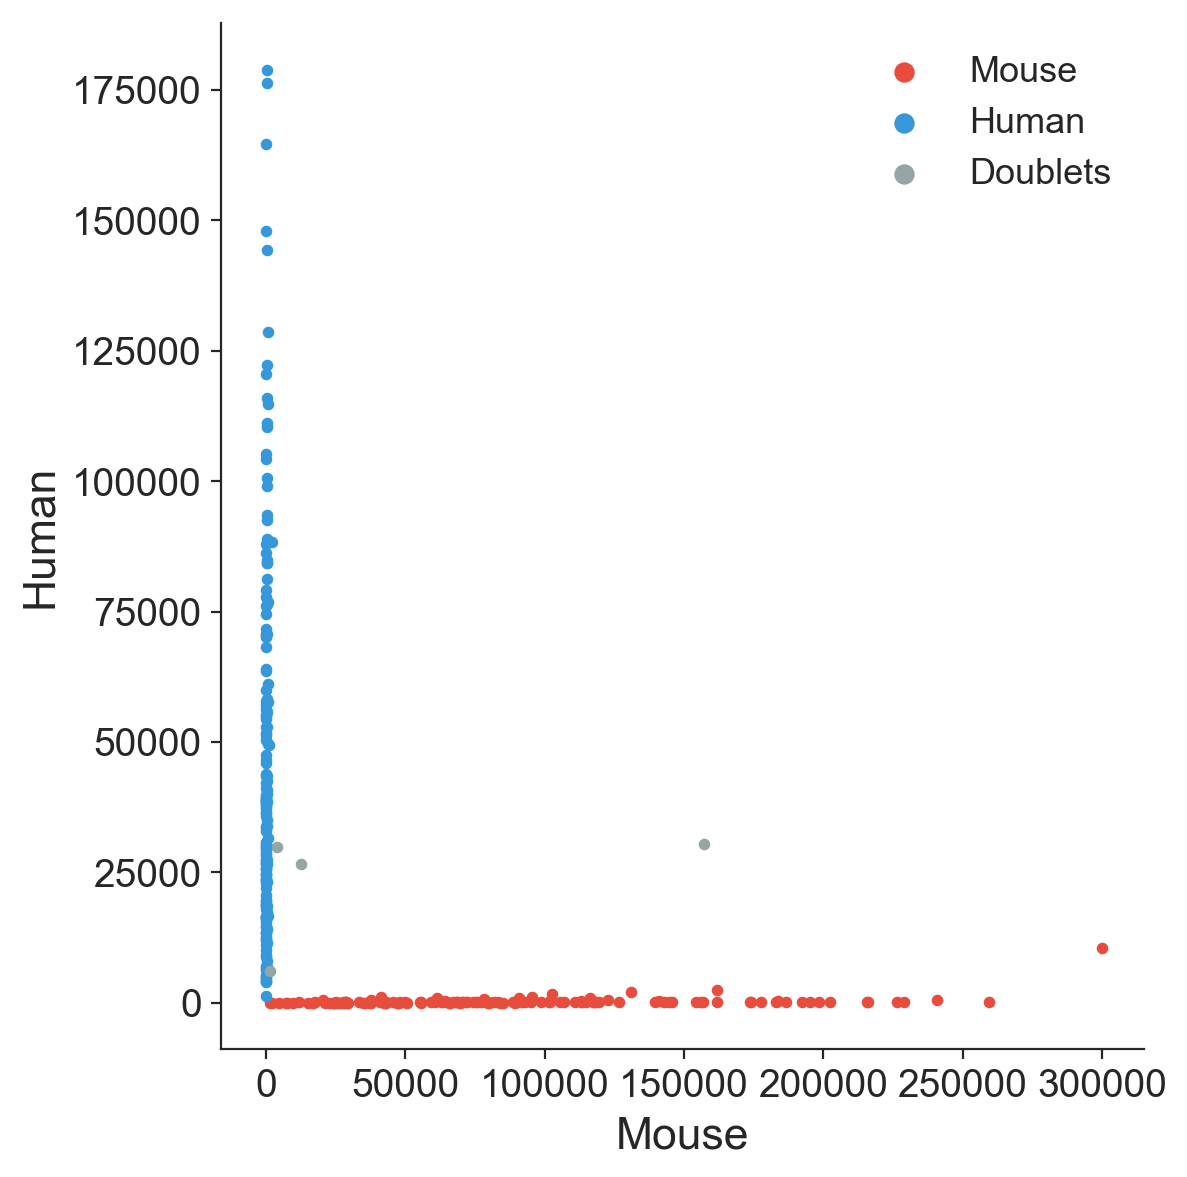

In [12]:
g = sns.FacetGrid(cells, height=6, hue='species')
g.map(plt.scatter, 'mm', 'hs', s=10)

g.ax.set_xlabel('Mouse')
g.ax.set_ylabel('Human')
g.ax.legend(frameon=False)

plt.savefig('figures/hek293t_nih3t3_mix.pdf',
            bbox_inches='tight', transparent=True)